In [1]:
import numpy as np

with open('data/text_data/japan.txt', 'r') as f:
    txt = f.read()

    X = []
    y = []

    char_to_idx = {char: i for i, char in enumerate(set(txt))}
    idx_to_char = {i: char for i, char in enumerate(set(txt))}

    X = np.array([char_to_idx[x] for x in txt])
    y = [char_to_idx[x] for x in txt[1:]]
    y.append(char_to_idx['.'])
    y = np.array(y)

In [2]:
import impl.layer as l

class GRU:

    def __init__(self, D, H, L, char2idx, idx2char, p_dropout):
        self.D = D
        self.H = H
        self.L = L
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'smooth train':[]}
        self.p_dropout = p_dropout
        
        # Model parameters
        Z = H + D
        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.),
            bz=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )
        
        self.model = []
        for _ in range(self.L):
            self.model.append(m)
            
    def initial_state(self):
        return np.zeros((1, self.H))

    def dropout_forward(self, X, p_dropout):
        u = np.random.binomial(1, p_dropout, size=X.shape) / p_dropout
        # q = 1-p_dropout
        # u = np.random.binomial(1, q, size=X.shape)
        out = X * u
        cache = u
        return out, cache

    def dropout_backward(self, dout, cache):
        dX = dout * cache
        return dX
    
    def selu_forward(self, X):
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        out = scale * np.where(X>=0.0, X, alpha * (np.exp(X)-1))
        cache = X
        return out, cache

    def selu_backward(self, dout, cache):
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        X = cache
        dX_pos = dout.copy()
        dX_pos[X<0] = 0
        dX_neg = dout.copy()
        dX_neg[X>0] = 0
        dX = scale * np.where(X>=0.0, dX_pos, dX_neg * alpha * np.exp(X))
        return dX

    # p_dropout = keep_prob in this case! 
    # Is this true in other cases as well?
    def alpha_dropout_fwd(self, h, q):
        '''h is activation, q is keep probability: q=1-p, p=p_dropout, and q=keep_prob'''
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        alpha_p = -scale * alpha
        mask = np.random.binomial(1, q, size=h.shape)
        dropped = (mask * h) + ((1 - mask) * alpha_p)
        a = 1. / np.sqrt(q + (alpha_p ** 2 * q  * (1 - q)))
        b = -a * (1 - q) * alpha_p
        out = (a * dropped) + b
        cache = (a, mask)
        return out, cache

    def alpha_dropout_bwd(self, dout, cache):
        a, mask = cache
        d_dropped = dout * a
        dh = d_dropped * mask
        return dh
    
    def forward(self, X, h, m, train):
        Wz, Wh, Wy = m['Wz'], m['Wh'], m['Wy']
        bz, bh, by = m['bz'], m['bh'], m['by']

        X_in = X.copy()
        h_in = h.copy()

        X = np.column_stack((h_in, X_in))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)

        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        h = h_in + (hz * (hh - h_in))
        # equal to
        # h = (1.0 - hz) * h_in + hz * hh
        # or
        # h = h_in + (hz * hh)
        # or
        # h = h_in + hz
        # or
        # h = h_in + hh

        ## SELU + SELU-Dropout
        #         y, y_cache = l.fc_forward(h, Wy, by)
        #         y, y_selu_cache = self.selu_forward(y)
        #         y = X_in + y
        #         if train: # with Dropout
        #             y, y_do_cache = self.alpha_dropout_fwd(y, self.p_dropout)
        #             cache = (h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache, y_selu_cache, y_do_cache)
        #         else: # no Dropout: testing or validation
        #             cache = (h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache, y_selu_cache)
        
        y, y_cache = l.fc_forward(h, Wy, by)
        y = X_in + y
        
        if train: # with Dropout
            y, y_do_cache = self.dropout_forward(y, self.p_dropout)
            cache = (h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache, y_do_cache)
        else: # no Dropout: testing or validation
            cache = (h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache)

        return y, h, cache

    def backward(self, dy, dh, cache, train):
        if train:
            h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache, y_do_cache = cache
            dy = self.dropout_backward(dout=dy, cache=y_do_cache)
        else:
            h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache = cache
        
        dy_out = dy.copy()
        dh_out = dh.copy()
        
        dh, dWy, dby = l.fc_backward(dy, y_cache)
        
        dh += dh_out
        dh_in1 = dh * (1.0 - hz) # res

        dhh =  dh * hz
        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)
        
        dhz = dh * (hh - h_in)
        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)
        
        dX = dXz + dXh
        
        dh_in2 = dX[:, :self.H]
        dh = dh_in1 + dh_in2 # res cells
        
        dX = dX[:, self.H:]
        dX += dy_out # res layers

        grad = dict(Wz=dWz, Wh=dWh, Wy=dWy, bz=dbz, bh=dbh, by=dby)
        
        return dX, dh, grad
    
    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())
            caches.append([])
            
        for X in X_train:
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], cache = self.forward(X, h[layer], self.model[layer], train=True)
                caches[layer].append(cache)
                X = y.copy()
            ys.append(y)
            
        return ys, caches

    def cross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        prob = l.softmax(y_pred)
        log_like = -np.log(prob[range(m), y_train])
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        grad_y = l.softmax(y_pred)
        grad_y[range(m), y_train] -= 1.0
        grad_y /= m

        return grad_y
    
    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += self.cross_entropy(y_pred, y)
            dy = self.dcross_entropy(y_pred, y)
            dys.append(dy)
            
        return loss, dys

    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for layer in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            
        dXs = []
        for t in reversed(range(len(dys))):
            dy = dys[t]
            for layer in reversed(range(self.L)):
                dX, dh[layer], grad[layer] = self.backward(dy, dh[layer], caches[layer][t], train=True)                
                for key in grad[layer].keys():
                    grads[layer][key] += grad[layer][key]
                dy = dX.copy()
            dXs.append(dX)
                
        return dXs, grads
    
    def test(self, X_seed, h, size):
        chars = [self.idx2char[X_seed]]
        idx_list = list(range(self.vocab_size))
        X = X_seed
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())

        for _ in range(size):
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.0
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], _ = self.forward(X, h[layer], self.model[layer], train=False)
                X = y.copy()
                
            prob = l.softmax(y)
            idx = np.random.choice(idx_list, p=prob.ravel())
            chars.append(self.idx2char[idx])
            X = idx

        return ''.join(chars)

    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        # for i in range(0, X.shape[0] - minibatch_size +1, 1):
        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def adam_rnn(self, X_train, y_train, alpha, mb_size, n_iter, print_after):
        M, R = [], []
         
        # Hidden layers
        for layer in range(nn.L):
            M.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            R.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
         
        beta1 = .99
        beta2 = .999
        eps = 1e-8
        state = self.initial_state()
        smooth_loss = 1.0
        minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=False)

        # Epochs
        for iter in range(1, n_iter + 1):
            # Minibacthes
            for idx in range(len(minibatches)):
                X_mini, y_mini = minibatches[idx]
                ys, caches = self.train_forward(X_mini, state)
                loss, dys = self.loss_function(y_train=y_mini, ys=ys)
                _, grads = self.train_backward(dys, caches)
                self.losses['train'].append(loss)
                smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
                self.losses['smooth train'].append(smooth_loss)

                for layer in range(nn.L):
                    for key in grads[layer].keys(): #key, value: items
                        M[layer][key] = l.exp_running_avg(M[layer][key], grads[layer][key], beta1)
                        R[layer][key] = l.exp_running_avg(R[layer][key], grads[layer][key]**2, beta2)

                        m_k_hat = M[layer][key] / (1. - (beta1**(iter)))
                        r_k_hat = R[layer][key] / (1. - (beta2**(iter)))

                        self.model[layer][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + eps)

            # Print loss and test sample
            if iter % print_after == 0:
                print('Iter-{} loss: {:.4f}'.format(iter, loss))
                sample = self.test(X_mini[0], state, size=100)
                print(sample)

Iter-10 loss: 108.6161
e p"E%ulptgat.oef ,shooiTig,ai:,eeRTieCheheti A1da,wiluo8t ftefrt poorid La  oy mooai auhlaeu ii me  
Iter-20 loss: 104.6498
eLu
tanay mcaa  tr v  ox iehmh1morn  ssnd)utchmtSiixn ep .f iihern reeyl va-, aheegRpe  ey se pwd oee
Iter-30 loss: 102.6231
eywvo w1an wneAel2 uHexry UaC9iLam4etIpP-nidakehdr tan.hs a pR ttAscsu ooni. s2 eea ie  shad onn bnob
Iter-40 loss: 102.7918
eexSSkarhWrrtu06  rrfnntiiont E"rettonrs. tiinr(nJdl ip ia  ohca il dahi eJ  ,pcanOa  heuirT  Infrofp
Iter-50 loss: 99.3490
eAAipk  irf4Idnnes thereeJPhop fnnth lngrsri uureadct. hn8 anTolnr  mP i.ne ir w mi he ysiaR  aokan  
Iter-60 loss: 97.9766
e% 30eero,roiSd Eayta  ohsI sfe ofduSy nes dar aketay t i ienrwco  hr fore t27cAws  ats sso ibRgodWsc
Iter-70 loss: 95.8533
esmcdnnv iies ioeASnlnf d1lge cinm'ieh-mu cynta re lnpy osrcchar atw ulitcaxz a1up fi5aW foshapa dii 
Iter-80 loss: 93.1826
e.myeGe isdJGhnpnnwire Ind caitey3 haswot ef pnmT ehee kon leph , tt–e oue
TdFinscolt cpirnd本dspoaalc
Iter

Iter-670 loss: 60.1091
ex crnsergerlar ou and hanley ad acpes angy panie of ural Japan by iEgS as andstanceace gh vagand Kof
Iter-680 loss: 63.6160
e–Wir des rurel inets as nous thred wris Ghelad insox.j iterolleworu ...D: ta as ofelopperea uthe whr
Iter-690 loss: 55.1097
eins and povukewoW 9ogth capardiccalnict oe:b2  punnnoky non  opresto fed itea an , is th-catwers tae
Iter-700 loss: 60.7561
e Redis fe ri6erys. If bor miun fk5ring. mpirate ir khes1 Haeentry it ood tery P1nond reos HereshareC
Iter-710 loss: 55.9879
eT, ooked East bate the :OmR2日r Lopand wh sg-phuroo onL6o-oaiteky Brangas ands of Japan4s wes cerral 
Iter-720 loss: 57.2089
erina whilc. Japan Im,es. Worthe "actes on maturiast Hy as s0 andeSallowyith is thevh rl6hsst iranarc
Iter-730 loss: 55.7592
elsacgoithe wofth regbyms com7t liparih the wan cf Chgint eme cound Dorudi47, 3 hacenciustarly figh t
Iter-740 loss: 66.3093
e" alin wh the woCticeunbit mncittr cppreg as expan  sfedEprrxeala. in thethetis thr arlaese te cagao


Iter-1330 loss: 35.4976
e asd wormpJapand the EAstpergest ury fa s maole. Area of 1941, Em exdrsiteving vnor fi1nts in 194y w
Iter-1340 loss: 38.6828
eE storeoped f ortl bod dmit tucand d intaL ev dopit liculatie the wLes Nrgpor logive onsirentury. Ni
Iter-1350 loss: 31.3522
eina an Asinnau wand aced 19th lnvularil tonn ineryos thes relolapee tho wand Asihed mest or pintemoe
Iter-1360 loss: 39.7248
es lef mppore we ile Ware Japan Pe aa the four Eurblobu it 18is and chulethe eag tevon1 the world 2ml
Iter-1370 loss: 38.0938
e ef J8eknanby antithe thor1m7imlingowwoky. TAAlotlentud of jo Nidod Jafan's micexth tamelest rintuti
Iter-1380 loss: 35.1905
ed bomtirste the aily inp1ediind is arecetil thit roncelsm ented enobo penme perceaked of Japan se eo
Iter-1390 loss: 30.2487
ed bar antrowet in the lapise anucballowa, the hipbealed foret trsu tuot rnget.win an the foummil tha
Iter-1400 loss: 35.0199
exta limgeat in moulios lith lllifesig Eas as atsed bipalacitch 9git-wenkI itse "rinttyis ates

Iter-1990 loss: 22.5397
eincreciinty in wor1d 37 und wor6d'sPWlithix. Japan suralaia a. Japan'suvind hrs coted Japan in Dareo
Iter-2000 loss: 20.3923
eD anded ofetre lake ch thicheal Is ose Caite nupat on porata ie 35 meilargT tored fome talite fed Eu
Iter-2010 loss: 24.1808
evbo an1y The goprorea, m3y inkel Warkeo an hiconnred 9acd atylount hininas Inin mait endiperanded mh
Iter-2020 loss: 23.2240
e; fobmel bompent ye fors  arhes urgas, the Cound-ras, in tho nand inuthe Rissowexth thet urilatiry 9
Iter-2030 loss: 20.1507
ed finst ertatien Inita ind ial tirisinl Siaice is f ome East warthe worm lrlurokk. In par copet occ0
Iter-2040 loss: 33.6716
ed romeicethe mald anm liinounde920Gme-narty wund the coflory Warsh meles romelorly whit hingutst in 
Iter-2050 loss: 25.4317
er otateon in the Emperore wosu ex aring,and inath , athe G9.garon ha asd grondesrolyo preateont fofr
Iter-2060 loss: 20.0066
etlono the 37 pef-ofine Snange to topuncensu lobuliandin wand Htesthe worg sturlomIldea, mand 

Iter-2650 loss: 17.1195
ecliom ition. Inpund connt's lonnme-lenowdive hi thend comest tid arcminary. Anircband Ghe G8GGPlcand
Iter-2660 loss: 25.6450
ecincexsmporngbt tont fiol fomel ef th the acan eckionty chegest gint-intby pext rtand es ite tilnd J
Iter-2670 loss: 18.5944
emecelag iconnty wontr ind uured CTofghtvll.kederccof opel bambca the wots cicnthe whorlallerimsitaty
Iter-2680 loss: 19.2104
epecicalith and the Nourligonigg un sd Japan, whet ty Bstox. Cowno"Japanail Wargest es int rolod.7TTy
Iter-2690 loss: 22.2073
ey 9ouras ercedety deio o thiparcesia meIhisin. NAsprepelith c.pred Japan is at Cower Wextar wEs tunt
Iter-2700 loss: 13.2977
e War of Japan, 1hh ce rediowd worthe Tok lopol tnonof. or thety. Topon and if Hasis. The Copand sham
Iter-2710 loss: 20.6240
e moltronlowinc efentrpy bu tigu, Has canalacardes arexpand ofrealy, the atred ate o9 any shanan moul
Iter-2720 loss: 18.1447
e loverrad oh c. Japan ind astio aigh uarlymMentrty foptr asiand fofloty ioltin thig cound War

Iter-3310 loss: 18.1355
e of 1s3y . of 193ty fectorlgban re the ou, thid coule iregha, the Rucsorlobal coflopF rt the ngrta i
Iter-3320 loss: 15.4263
es of the Sabned Tof crand is a, woin"an tinntitiwent in bint ofod Fiates Tof eopan Dy founto-keoplop
Iter-3330 loss: 20.0080
ered inti teront miintein wand thothe meobol eate louponper mpinind andin re tio woxt rpreniogepand o
Iter-3340 loss: 21.4028
el of Asored ing imsestury sliced th Gn paleedectare warc ofela, has Hakakes wes drcetiotthecetsi lov
Iter-3350 loss: 27.4548
ed fore thesto lobainy has wof lopen by bo bed Eas ancEmperest China esman wes refas y fed rollalilat
Iter-3360 loss: 17.7889
e2 The Ooban y crgodtw-inht orid noustr. of the lith it thes frestary in Cigatun Emse tol worcd in th
Iter-3370 loss: 14.4859
e first en thendentf copan ms andrun 98Ch in thin Eurto NnopI pexpoponane Nspepondof as periogler ast
Iter-3380 loss: 11.2720
ely pef urstopul trop loredsine GNoband The worid Siny 1m4in wasd the Grlaturil 1868, andat to

Iter-3970 loss: 15.3171
eW of lith an the nari mbyn, th and Wardon woc lrcaidint fiol ith arctivininge wil io th yn ngesu in 
Iter-3980 loss: 11.8221
e tho worgdst ir 19th ceand es-Onand ia d whiliconn-desty- anly-peopnl tren fo mppeponnt porocnty sea
Iter-3990 loss: 12.8562
e Worly pntre ficaty ce puriti. Tovy cote th  anbe penowd, thvea ceutio Oightureatil wint ofrlapalcti
Iter-4000 loss: 11.1706
e porom. The Sha anar-.mnte The couter esta oxth . Arth of on Nob-lalked ituthe wird Japan wixth cebu
Iter-4010 loss: 9.1844
ed in th bnwtil mextinlapleinovina Is andin fomel Weree lspenote the aols recoded aren moperaledwint 
Iter-4020 loss: 11.8535
ed War soularge1 ty On and fousth-cereasivy As argeth rs aressty ficctind sorch Wer deunonI Wirgeat e
Iter-4030 loss: 8.7021
e roglomper limanitan so the whrl Japann" tainan igat to toltenis ar himane who the and cacdeat e of 
Iter-4040 loss: 26.0680
e tored. Stat of1ilgrecluwir himain diat of in bolo9, by urcAdis. Actakedicwo rogst ares tfrc bo

Iter-4630 loss: 26.6369
ed in the noul righea me 18ghs atuke Co the worl Cionto incen, is arowith inst irinigule walu uruge"L
Iter-4640 loss: 20.7816
e fogstuted ir Combiv nase vard Japan (opexa"can", ised In esoretoun vifrontxrlygand the liti of in t
Iter-4650 loss: 19.1730
e tofli. The aa peatern. front the cembel if fimar country is thice arls wirt onelomy ntate worl bira
Iter-4660 loss: 7.4458
ed cofrcat ligh tional omy tont wint in byuperceasing mpilarcexty unckedesiced Chice parildtio thrt o
Iter-4670 loss: 13.9394
ed in the worud thy , Palde to the ans  rogutures Tokyo an by ponted arge pornedsived paral Japan ty 
Iter-4680 loss: 10.7537
ed cof the lames. The canfed prage cppolithe wormeclint Dy cogudith in the Upleren t on rnknoun gichi
Iter-4690 loss: 11.1569
ed East opplaties of che tores an orflottilicenid Anind's ofod a as andertal wotl Wirgas sed iand a t
Iter-4700 loss: 20.9174
e firctoen of 1937 NsPatonn wort City or kion al soent Dinteo il hiomtint ond cincerserthe fich

Iter-5290 loss: 6.3839
er. Tity once foptr and Itienweid angs pardeced in Chur anlI. Japan was ccfutstuliche tso eand Nchasl
Iter-5300 loss: 10.3990
e Worl Copuncense larl combor and ateknard of Jdeand nf uteltopun as is aresthec pores lf pspand arge
Iter-5310 loss: 16.7018
ed forst toredsitee of the citse wors Japan, the wares louniop ese the Gfrican Inied ofod thhe caulow
Iter-5320 loss: 7.7446
ed pores turas, thican thin late chute, whin 1ith cented lofrom thet t il tiodwe trentowun rccins- un
Iter-5330 loss: 13.2419
e toryd, whes apalope peasirun Index parlevicate pive ewsi A Asia. Lhestaryes Tok ovitarthe whis lrun
Iter-5340 loss: 8.4506
e porliciniry BAronly, Japan his arest iontro exth pand of and rxas aidi. nomel pard the Eury re lofu
Iter-5350 loss: 14.5176
epercened frint wio tho aodi. Japan ista an hu andel ofj1, t rextolitokio Aitanowo ad hasos wond stur
Iter-5360 loss: 14.0230
ery Brdes the woprl irgist. The couter ig tioteit tinoth thethe micb and Wand whin. A pano ilatoI

Iter-5950 loss: 13.4991
ed atin weud Wirt in lato of unea woit 1igontr tnttil ands ncopor and Shakeowd d resterich surid Chin
Iter-5960 loss: 9.2493
ed country in the Glrey EArea. I Seator ofo6, KKmprealarig tiod ite ed nored en des. coturaith . Star
Iter-5970 loss: 6.6831
e ficttind foulom W7 trenes an poporate y cedorn mhinarackkai wh, hassichaslamtin easd fhist enured c
Iter-5980 loss: 16.6748
ed filht erter. Iiwed by tod oby , parlectire"king ar lstarof is earth the East opel tien. pppred co 
Iter-5990 loss: 7.3027
ered into celouliturang ande. The Gapeeteo ive In lovanc ase apore world Worglop efer cianel iven, st
Iter-6000 loss: 5.6471
erconad then"ente in Japan toves patienteit inalicolicalicas asd rarse worldcWanly proportyo wory ly 
Iter-6010 loss: 8.3145
expaclarized Winted in thi canne was andit andet of Jmpan, ate narsowaicencesiad Japan is lowas pront
Iter-6020 loss: 8.2368
e, the wrlat-rove Se tof nolutiec ing1st excithe Worguttty ted ented Wand country 9eas an Japan to e

Iter-6610 loss: 10.1769
ely. The canse Wart Asea, syicod in hisingl test pereate ulat8en latuont. Inte ported of frcctaned ig
Iter-6620 loss: 11.0431
ed War solledecodi, Japan the miphe poremcldjont haratd of the Nas ing1 the was drcithicaney h in 194
Iter-6630 loss: 4.8272
e torys. Sh mesereclaresiculal solaHlyowt. pentory. In ucht oxth Wnked boulot miobt nisive ul isoly u
Iter-6640 loss: 13.8515
er and Winter OlyD. chares toredsic thithe whit hincanked frud at Inie lout ronte porea lygsrxparlich
Iter-6650 loss: 10.0519
ed ia tho cand of aneto nicudictby wit ic lomesstof ompan the wand o, hasicllomImber3e an'sd and of n
Iter-6660 loss: 5.1373
expaclaringh. Napend ofulive porId ofjic tatted an s. papol poritakin mail whit ricctunt whe worsd bo
Iter-6670 loss: 7.4553
e pored Emperop and War war ssif okvige lfel rith pope ae hicanese wont riatel 19th an aldei whith  a
Iter-6680 loss: 9.7524
ed first in the Wurld Olymst. Theancof ol Jopan, Inden, fred xth the Emseroulan Da lorterin fiulat

Iter-7270 loss: 4.3812
ed first in the number of Nobel laureates of any country in gist f rsatornaly of the cobnl Warly in f
Iter-7280 loss: 10.9216
e torod. , the warl mby-du, the nagS a, intet ondtron dentivea lo sittolition ripeared The charesture
Iter-7290 loss: 9.6201
ery Br add Wontul whid 1atic nand whi has haised in the ward stokidint I of Japan's ficstacl chaitony
Iter-7300 loss: 7.2446
e of 6, porlinid lewo, inola anty unotoku arth thety pe tory irud Wnr c laino ty un tokeo ped eonte p
Iter-7310 loss: 6.5803
e world's largest metropolitan area with over 35 million residents and the Eopes peastry ot liontiry 
Iter-7320 loss: 10.0216
er. Tity on ticon. Stumaredin miof as h sand chan, thena. Trean aidiceth  esite-nat eiwio the aoust.r
Iter-7330 loss: 14.2309
e7 of the nsm ofit, y and Ast word Japan, it tith progeate d Atal tod lomess inst milioand atal andil
Iter-7340 loss: 11.1439
ed fores arult.dTTeecenim Japan (Japanesed Pace perore tire en ty an rumeity ar Asian hasestrecetr

Iter-7930 loss: 3.9295
ed first in the nembol worsh vered inundec ofld perala aiwed coutsr wost rich ant ofrowaichase fimh a
Iter-7940 loss: 9.7086
e porita novin ang ad Japan "s an e fiot er lowil puls arss porter ag tor o, the the world'i eand the
Iter-7950 loss: 12.0124
ed ficht ar UNinnd of 68vestandecticlares high rameichte an e lowtre the sursic. ot mpind-perning por
Iter-7960 loss: 7.9175
ered into a lend purne I of or wnor aluntry wed se coubed col esichesid hicht and Warly popa Wer. A t
Iter-7970 loss: 6.9390
e fors ure", the woth cWrrens. Artarty se lores arges wend pirf-surth in aed ing1mp land the world re
Iter-7980 loss: 3.9608
ed first contropalimen thes urulsered and cand par as inandecedecter andec ase late fopmt ardesten fo
Iter-7990 loss: 17.1785
ed first in the number of Nobel laureaper hai, ah mbir loggetter Oygintben r as enfid bons of Wor cba
Iter-8000 loss: 4.2567
etery coty of Jopan, an mandensu the RissorIOdesticeadlide tixnec. is the Risstuty coptert ounho en 

Iter-8590 loss: 8.7233
e world's largest mitbtron Empixpernarit. Tofya  io tht with curnd Sin Couund, Chy and inund, it orgh
Iter-8600 loss: 5.4110
ed first in the number of Nobel laresturinctio tho aidetein Gijo rctering indby wrod the Rigith cngme
Iter-8610 loss: 3.7294
er and Winter Olympic Games.
. Japan in tas anct. en unitulywwo, maialaized Japan was reconimint and 
Iter-8620 loss: 4.6527
e Paleo inturea ligcan emper argCha angh alacling fiod comber as man thinglat in handof anest andrext
Iter-8630 loss: 9.0964
er of Hovinh asel of 1868ccllith ivsthe bore pirulitiving mfilatimy cotben Empesart Indextwona ited o
Iter-8640 loss: 3.8900
e porlobar mailitans acunnty inutory A is arec inctory int, in the warly. Firth lfrulstio titt ored T
Iter-8650 loss: 4.9837
ed ais tenc poret. Tie Eost Arithen Emponal mokelly severes ivenal mponturing1 th an thenpeoild. pret
Iter-8660 loss: 7.1857
er and Winter Olympic Games.
. Japan in tara an hostional mitateon en the suphe esored Anid aaclith a


Iter-9250 loss: 7.4955
e world's largest mbintron Easimes an the ados wfol mpkrons arunst molrorithes veredoflich anest. nat
Iter-9260 loss: 7.1634
e world's largest metropoliga a at'ras intexparcea, bandec, mby 20asuncEas and the hostrrtailed is as
Iter-9270 loss: 3.2083
expaclare mhe porulithicliontex whfres lfessutaricinea wed ionth the wort wond Japan wardecthor count
Iter-9280 loss: 7.6662
e Peadent of rotityeng Aslal cofrlopt it tins Wfresl ferereake con maulaty of cticed com eted ivingr 
Iter-9290 loss: 8.3217
ery Br Co6 itbin ay hingwal d ind rill. Is andin aiunarcmonity woth lapmeleilininu aroin boural thest
Iter-9300 loss: 5.8430
e Peleoper as hison Japan in ty nopala a cedicte nfrlallecttrearly and tho apper as sapor Olhy westic
Iter-9310 loss: 7.8111
ed ficht as uraglitne wos d's thes 1mtlipirins. In or and ofula, hy ssulexpmelednof. utprreciged fors
Iter-9320 loss: 3.3712
es of the ncabed Wd nor ainst cofntte eitivin tilo wat  ofro, papana an's inm16 The and rurog Wir lec


Iter-9910 loss: 5.9632
er and Winter Olympic laposara. Tovec po fod tete pore four 9hulange nessow othe 1rth nar hat o parin
Iter-9920 loss: 11.7632
ed fors apalitivinas whith c gimts peetor O9w5s mioneowUrine1 Krectand ighat Co notulivithe Rursove n
Iter-9930 loss: 6.4247
er. The ciuntr ieatiny ward iteCtineal coOl. 1st revenwes Rens vertiealicina at inect oi houNia ,ist.
Iter-9940 loss: 7.0771
evened f ist tren uping s pr'p tioted The donto portertering is lf isppron Glucanded lof istar hesicc
Iter-9950 loss: 5.4694
ed first in the Wurly lomfob ea3e mbaa wod lofil's lata nted nind it the purnglRuged, micl aros fored
Iter-9960 loss: 11.2489
e world's largest metropol tof torla, woth largest and frrst weitiry of. Toty by ss f prmaired atiena
Iter-9970 loss: 12.8611
e porimal ey Asoand theghupallImiea an Japan was sapal tosto paited ar Niontron an of liviniman insta
Iter-9980 loss: 9.0895
e world's largest metropolitan area with over 35 million residents and the world's largest Areanici

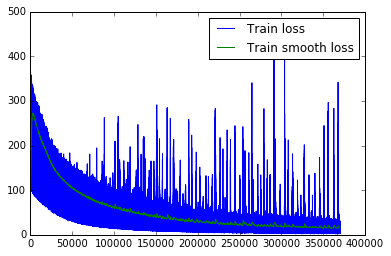

In [3]:
# Hyper-parameters
time_step = 100 # width, minibatch size and test sample size as well
num_layers = 1 # depth
n_iter = 10000 # epochs
alpha = 1e-4 # learning_rate
p_dropout = 0.95 # q=1-p, q=keep_prob and p=dropout.
print_after = 10 # n_iter//100 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
nn = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, p_dropout=p_dropout, char2idx=char_to_idx, idx2char=idx_to_char)

# Start learning using BP-SGD-ADAM
nn.adam_rnn(X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()